In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mxnet
!pip install torch
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 38.9 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.5/344.5 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp310-cp310-linux_x86_64.whl size=661636 sha256=2deeb5d5f6abb0ba86c7d43c0d1732cb106924057293f85e5207273e18c4f28c
  Stored in directory: /root/.cache/pip/wheels/1a/1e/0d/99f55911d90f2b95b9f7c176d5813ef3622894a4b30fde6bd3
Successfully built gluonnlp
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 114.8 MB/s eta 0:00:00
     ━━━━

In [ ]:
# 깃허브에서 KoBERT 파일 로드
# !pip install git+https://git@github.com/SKTBrain/KoBERT.git@master -> 오류 날 수 있음

!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf' # hugging face를 통한 모델 다운로드 방식

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-15zcss8m/kobert-tokenizer_f1eaec3dbfee42af9c15f01db9f87aef
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-15zcss8m/kobert-tokenizer_f1eaec3dbfee42af9c15f01db9f87aef
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done
  Created wheel for kobert_tokenizer: filename=kobert_tokenizer-0.1-py3-none-any.whl size=4633 sha256=de285fa925ad37c88017fe61998cd1a42f6abbd3a02df8cc879bcf1c3b0aea1b
  Stored in directory: /tmp/pip-ephem-wheel-cache-pqyywpmg/wheels/e9/1a/3f/a864970e8a169c176befa3c4a1e07aa612f69195907a4045fe
Successfully built kobert_tokenizer


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
import os
import sys
import numpy as np
import pandas as pd

import torch
from torch import nn
import torch.optim as optim
from torch.optim import AdamW
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import gluonnlp as nlp
from tqdm.notebook import tqdm
from tqdm import tqdm, tqdm_notebook

In [ ]:
# Hugging Face를 통한 모델 및 토크나이저 Import
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel
from transformers import get_cosine_schedule_with_warmup
from transformers.optimization import get_cosine_schedule_with_warmup

In [ ]:
#GPU 사용
device = torch.device("cuda:0")

### 말뭉치 데이터

In [ ]:
train_dataset = pd.read_csv('/content/drive/MyDrive/YBIGTA/YBIGTA 투게더 프로젝트/대화 데이터/감성대화말뭉치(전처리)_Training.csv')
test_dataset = pd.read_csv('/content/drive/MyDrive/YBIGTA/YBIGTA 투게더 프로젝트/대화 데이터/감성대화말뭉치(전처리)_Validation.csv')

In [ ]:
train_dataset.loc[(train_dataset['감정_대분류'] == "기쁨"), 'Emotion'] = 0
train_dataset.loc[(train_dataset['감정_대분류'] == "슬픔"), 'Emotion'] = 1
train_dataset.loc[(train_dataset['감정_대분류'] == "분노"), 'Emotion'] = 2
train_dataset.loc[(train_dataset['감정_대분류'] == "불안"), 'Emotion'] = 3

In [ ]:
test_dataset.loc[(test_dataset['감정_대분류'] == "기쁨"), 'Emotion'] = 0
test_dataset.loc[(test_dataset['감정_대분류'] == "슬픔"), 'Emotion'] = 1
test_dataset.loc[(test_dataset['감정_대분류'] == "분노"), 'Emotion'] = 2
test_dataset.loc[(test_dataset['감정_대분류'] == "불안"), 'Emotion'] = 3

In [ ]:
train_dataset['Emotion'] = train_dataset['Emotion'].astype(int)
test_dataset['Emotion'] = test_dataset['Emotion'].astype(int)

In [ ]:
# 텍스트, 레이블 형태의 리스트로 변환

train_data = []
for q, label in zip(train_dataset['사람문장'], train_dataset['Emotion']):
    data = [q, str(label)]
    train_data.append(data)

test_data = []
for q, label in zip(test_dataset['사람문장'], test_dataset['Emotion']):
    data = [q, str(label)]
    test_data.append(data)

In [ ]:
train_data[0]

['일은 왜 해도 해도 끝이 없을까? 화가 난다. 그냥 내가 해결하는 게 나아. 남들한테 부담 주고 싶지도 않고. ', '2']

In [ ]:
len(train_data), len(test_data)

(42874, 5593)

#### BERT Sentence Transform 새로 정의 - py파일에서 따로 가져옴

In [ ]:
class BERTSentenceTransform:
    r"""BERT style data transformation.

    Parameters
    ----------
    tokenizer : BERTTokenizer.
        Tokenizer for the sentences.
    max_seq_length : int.
        Maximum sequence length of the sentences.
    pad : bool, default True
        Whether to pad the sentences to maximum length.
    pair : bool, default True
        Whether to transform sentences or sentence pairs.
    """

    def __init__(self, tokenizer, max_seq_length,vocab, pad=True, pair=True):
        self._tokenizer = tokenizer
        self._max_seq_length = max_seq_length
        self._pad = pad
        self._pair = pair
        self._vocab = vocab

    def __call__(self, line):
        """Perform transformation for sequence pairs or single sequences.

        The transformation is processed in the following steps:
        - tokenize the input sequences
        - insert [CLS], [SEP] as necessary
        - generate type ids to indicate whether a token belongs to the first
        sequence or the second sequence.
        - generate valid length

        For sequence pairs, the input is a tuple of 2 strings:
        text_a, text_b.

        Inputs:
            text_a: 'is this jacksonville ?'
            text_b: 'no it is not'
        Tokenization:
            text_a: 'is this jack ##son ##ville ?'
            text_b: 'no it is not .'
        Processed:
            tokens: '[CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]'
            type_ids: 0     0  0    0    0     0       0 0     1  1  1  1   1 1
            valid_length: 14

        For single sequences, the input is a tuple of single string:
        text_a.

        Inputs:
            text_a: 'the dog is hairy .'
        Tokenization:
            text_a: 'the dog is hairy .'
        Processed:
            text_a: '[CLS] the dog is hairy . [SEP]'
            type_ids: 0     0   0   0  0     0 0
            valid_length: 7

        Parameters
        ----------
        line: tuple of str
            Input strings. For sequence pairs, the input is a tuple of 2 strings:
            (text_a, text_b). For single sequences, the input is a tuple of single
            string: (text_a,).

        Returns
        -------
        np.array: input token ids in 'int32', shape (batch_size, seq_length)
        np.array: valid length in 'int32', shape (batch_size,)
        np.array: input token type ids in 'int32', shape (batch_size, seq_length)

        """

        # convert to unicode
        text_a = line[0]
        if self._pair:
            assert len(line) == 2
            text_b = line[1]

        tokens_a = self._tokenizer.tokenize(text_a)
        tokens_b = None

        if self._pair:
            tokens_b = self._tokenizer(text_b)

        if tokens_b:
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            self._truncate_seq_pair(tokens_a, tokens_b,
                                    self._max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > self._max_seq_length - 2:
                tokens_a = tokens_a[0:(self._max_seq_length - 2)]

        # The embedding vectors for `type=0` and `type=1` were learned during
        # pre-training and are added to the wordpiece embedding vector
        # (and position vector). This is not *strictly* necessary since
        # the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.

        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        #vocab = self._tokenizer.vocab
        vocab = self._vocab
        tokens = []
        tokens.append(vocab.cls_token)
        tokens.extend(tokens_a)
        tokens.append(vocab.sep_token)
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens.extend(tokens_b)
            tokens.append(vocab.sep_token)
            segment_ids.extend([1] * (len(tokens) - len(segment_ids)))

        input_ids = self._tokenizer.convert_tokens_to_ids(tokens)

        # The valid length of sentences. Only real  tokens are attended to.
        valid_length = len(input_ids)

        if self._pad:
            # Zero-pad up to the sequence length.
            padding_length = self._max_seq_length - valid_length
            # use padding tokens for the rest
            input_ids.extend([vocab[vocab.padding_token]] * padding_length)
            segment_ids.extend([0] * padding_length)

        return np.array(input_ids, dtype='int32'), np.array(valid_length, dtype='int32'),\
            np.array(segment_ids, dtype='int32')

In [ ]:
def get_kobert_model(model_path, vocab_file, ctx="cpu"):
    bertmodel = BertModel.from_pretrained(model_path, return_dict=False)
    device = torch.device(ctx)
    bertmodel.to(device)
    bertmodel.eval()
    vocab_b_obj = nlp.vocab.BERTVocab.from_sentencepiece(vocab_file,
                                                         padding_token='[PAD]')
    return bertmodel, vocab_b_obj

### 필요 클래스 정의 - Dataset, Classifier

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len,
                 pad, pair):
        transform = BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len,vocab=vocab, pad=pad, pair=pair)
        #transform = nlp.data.BERTSentenceTransform(
        #    tokenizer, max_seq_length=max_len, pad=pad, pair=pair)
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [ ]:
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')
tok = tokenizer

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [ ]:
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [ ]:
train_data = BERTDataset(train_data, 0, 1, tok, vocab, max_len, True, False)
test_data = BERTDataset(test_data, 0, 1, tok, vocab, max_len, True, False)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=2)

In [ ]:
train_data[0]

(array([   2, 3803, 7086, 3466, 5002, 5002, 1363, 7096, 3282, 5591,  258,
        5112, 5330, 1406, 5782,   54, 1189, 1435, 4999, 7794,  921, 1370,
        6797,   54, 1409, 5931, 7835, 2426, 4217,  517, 6751, 7328, 3149,
          54,    3,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1], dtype=int32),
 array(35, dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=int32),
 2)

### BERT 모델 설정

In [ ]:
### label 카테고리 개수에 맞게 num_classes 반드시 변경! (4개)

class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes = 4,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size, num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device), return_dict=False)   # <-- return_dict=False 추가했습니다
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)


In [ ]:
model = BERTClassifier(bertmodel,  dr_rate=0.5)
model.to(device)

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

In [ ]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [ ]:
#optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, weight_decay=0.01)  # weight_decay 설정 추가
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [ ]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

### 학습 및 저장

In [ ]:
train_acc_list = []
test_acc_list = []
train_loss_list = []

In [ ]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()     # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))

    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))

    train_acc_list.append(train_acc / (batch_id + 1))
    train_loss_list.append(loss.data.cpu().numpy())

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)

    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

    test_acc_list.append(test_acc / (batch_id + 1))

<ipython-input-32-382e6e484d0e>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/670 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 1.2202277183532715 train acc 0.609375
epoch 1 batch id 201 loss 0.25162428617477417 train acc 0.7347636815920398
epoch 1 batch id 401 loss 0.24257580935955048 train acc 0.7565461346633416
epoch 1 batch id 601 loss 0.48203322291374207 train acc 0.7523138519134775
epoch 1 train acc 0.7609672542460113


<ipython-input-32-382e6e484d0e>:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/88 [00:00<?, ?it/s]

epoch 1 test acc 0.5484659090909091


  0%|          | 0/670 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.9248467683792114 train acc 0.75
epoch 2 batch id 201 loss 0.21186630427837372 train acc 0.7723103233830846
epoch 2 batch id 401 loss 0.25285589694976807 train acc 0.7899002493765586
epoch 2 batch id 601 loss 0.5022362470626831 train acc 0.789855449251248
epoch 2 train acc 0.7981455867215645


  0%|          | 0/88 [00:00<?, ?it/s]

epoch 2 test acc 0.5675639204545454


  0%|          | 0/670 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.810463011264801 train acc 0.765625
epoch 3 batch id 201 loss 0.1565016657114029 train acc 0.804648631840796
epoch 3 batch id 401 loss 0.15038543939590454 train acc 0.8223192019950125
epoch 3 batch id 601 loss 0.3650444746017456 train acc 0.8230293261231281
epoch 3 train acc 0.8313593669583119


  0%|          | 0/88 [00:00<?, ?it/s]

epoch 3 test acc 0.5671875000000001


  0%|          | 0/670 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.6552801132202148 train acc 0.796875
epoch 4 batch id 201 loss 0.11144071817398071 train acc 0.8473258706467661
epoch 4 batch id 401 loss 0.12412728369235992 train acc 0.8568422693266833
epoch 4 batch id 601 loss 0.3140681982040405 train acc 0.8585170549084858
epoch 4 train acc 0.864799118630983


  0%|          | 0/88 [00:00<?, ?it/s]

epoch 4 test acc 0.6057386363636363


  0%|          | 0/670 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.4653571546077728 train acc 0.859375
epoch 5 batch id 201 loss 0.05370442569255829 train acc 0.8800528606965174
epoch 5 batch id 401 loss 0.09867417067289352 train acc 0.884156795511222
epoch 5 batch id 601 loss 0.24444864690303802 train acc 0.8842554076539102
epoch 5 train acc 0.8899696024189397


  0%|          | 0/88 [00:00<?, ?it/s]

epoch 5 test acc 0.6187997159090909


  0%|          | 0/670 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.4894421696662903 train acc 0.875
epoch 6 batch id 201 loss 0.022847535088658333 train acc 0.9081156716417911
epoch 6 batch id 401 loss 0.06184137985110283 train acc 0.9112375311720698
epoch 6 batch id 601 loss 0.18089653551578522 train acc 0.9089538269550749
epoch 6 train acc 0.9134328358208955


  0%|          | 0/88 [00:00<?, ?it/s]

epoch 6 test acc 0.6344247159090909


  0%|          | 0/670 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.3129434883594513 train acc 0.90625
epoch 7 batch id 201 loss 0.014646630734205246 train acc 0.9201648009950248
epoch 7 batch id 401 loss 0.029671214520931244 train acc 0.9252259975062345
epoch 7 batch id 601 loss 0.27895212173461914 train acc 0.920705074875208
epoch 7 train acc 0.924435473494596


  0%|          | 0/88 [00:00<?, ?it/s]

epoch 7 test acc 0.6914417613636363


  0%|          | 0/670 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.22544527053833008 train acc 0.953125
epoch 8 batch id 201 loss 0.017691997811198235 train acc 0.9237406716417911
epoch 8 batch id 401 loss 0.027712052688002586 train acc 0.9317331670822943
epoch 8 batch id 601 loss 0.270492821931839 train acc 0.9203410981697171
epoch 8 train acc 0.9236449755532682


  0%|          | 0/88 [00:00<?, ?it/s]

epoch 8 test acc 0.7376278409090908


  0%|          | 0/670 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.2260829508304596 train acc 0.96875
epoch 9 batch id 201 loss 0.024000030010938644 train acc 0.896532960199005
epoch 9 batch id 401 loss 0.016590984538197517 train acc 0.918446072319202
epoch 9 batch id 601 loss 0.7230241298675537 train acc 0.8944727537437605
epoch 9 train acc 0.877071538857437


  0%|          | 0/88 [00:00<?, ?it/s]

epoch 9 test acc 0.849765625


  0%|          | 0/670 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.37077829241752625 train acc 0.9375
epoch 10 batch id 201 loss 0.020144304260611534 train acc 0.9409203980099502
epoch 10 batch id 401 loss 0.016973726451396942 train acc 0.9431499376558603
epoch 10 batch id 601 loss 0.3663427233695984 train acc 0.9233049084858569
epoch 10 train acc 0.9256272516726711


  0%|          | 0/88 [00:00<?, ?it/s]

epoch 10 test acc 0.7603551136363635


In [ ]:
## 학습 모델 저장

path = '/content/drive/MyDrive/YBIGTA/YBIGTA 투게더 프로젝트/'
torch.save(model, path + 'trained_KoBERT_epoch10.pt')              # 전체 모델 저장
torch.save(model.state_dict(), path + 'epoch10_state_dict.pt')     # 모델 객체의 state_dict 저장
torch.save({
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict()
}, path + 'all.tar')                        # 여러 가지 값 저장, 학습 중 진행 상황 저장을 위해 epoch, loss 값 등 일반 scalar값 저장 가능

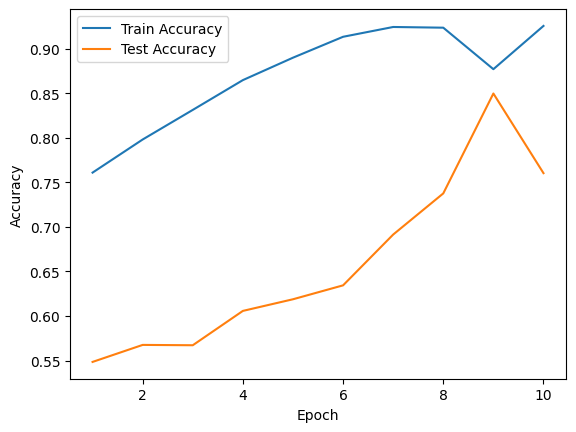

In [ ]:
import matplotlib.pyplot as plt

# 정확도 그래프
plt.plot(range(1, num_epochs + 1), train_acc_list, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_acc_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

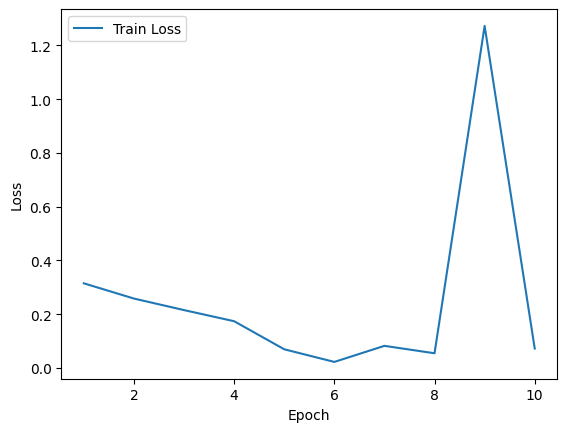

In [ ]:
# 손실 그래프
plt.plot(range(1, num_epochs + 1), train_loss_list, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 학습 모델 로드 및 사용

In [ ]:
# tokenizer, vocab, 기본 KoBERT model 불러오기 필수
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [ ]:
# KoBERT에 입력될 데이터셋 정리
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len,
                 pad, pair):
        transform = BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len,vocab=vocab, pad=pad, pair=pair)
        #transform = nlp.data.BERTSentenceTransform(
        #    tokenizer, max_seq_length=max_len, pad=pad, pair=pair)
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

# 모델 정의
class BERTClassifier(nn.Module):        ## 클래스 상속
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes = 4,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size, num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device), return_dict=False)   # <-- return_dict=False 추가했습니다
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)


In [ ]:
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [ ]:
## 학습 모델 로드

path = '/content/drive/MyDrive/YBIGTA/YBIGTA 투게더 프로젝트/'
model = torch.load(path + 'trained_KoBERT_epoch10.pt')             # 전체 모델을 통째로 불러옴, 클래스 선언 필수
model.load_state_dict(torch.load(path + 'epoch10_state_dict.pt'))  # state_dict를 불러 온 후, 모델에 저장

<All keys matched successfully>

In [ ]:
def new_softmax(a) :
    c = np.max(a) # 최댓값
    exp_a = np.exp(a-c) # 각각의 원소에 최댓값을 뺀 값에 exp를 취한다. (이를 통해 overflow 방지)
    sum_exp_a = np.sum(exp_a)
    y = (exp_a / sum_exp_a) * 100
    return np.round(y, 3)

In [ ]:
def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=2)

    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)

        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()
            min_v = min(logits)
            total = 0
            probability = []
            logits = np.round(new_softmax(logits), 3).tolist()
            for logit in logits:
                #print(logit)
                probability.append(np.round(logit, 3))

            if np.argmax(logits) == 0:  emotion = "기쁨"
            elif np.argmax(logits) == 1: emotion = "슬픔"
            elif np.argmax(logits) == 2: emotion = "분노"
            elif np.argmax(logits) == 3: emotion = "불안"

            probability.append(emotion)

    result = probability[-1]
    print(f"당신의 문장에서 {result}이 느껴집니다.")
    return probability

In [ ]:
prob = predict('지치고 힘들어서 휴학하고 싶어.')
prob

당신의 문장에서 슬픔이 느껴집니다.


[0.023, 98.221, 1.532, 0.223, '슬픔']

In [ ]:
prob = predict('교수님 너무 짜증나서 수업 철회할거야.')
prob

당신의 문장에서 분노이 느껴집니다.


[1.758, 1.406, 95.984, 0.851, '분노']

In [ ]:
prob = predict('내가 과연 잘할 수 있을지 모르겠어서 걱정돼.')
prob

당신의 문장에서 불안이 느껴집니다.


[0.105, 0.573, 0.57, 98.752, '불안']

In [ ]:
prob = predict('오늘 친구랑 케이크 먹으러 갔는데 너무 맛있었어') ## 감정 단어가 포함되지 않으면 예측을 잘 못 함... 데이터에 '친구랑' '가족이랑' 이렇게 시작하는게 많아서 그런가?
prob

당신의 문장에서 불안이 느껴집니다.


[0.825, 4.374, 37.486, 57.314, '불안']

In [ ]:
prob = predict('오늘 친구랑 케이크 먹으러 갔는데 너무 즐거웠어!') ## 감정 단어가 포함되면 얼추 잘 하긴 함...
prob

당신의 문장에서 기쁨이 느껴집니다.


[99.897, 0.042, 0.033, 0.028, '기쁨']

In [ ]:
# 자유롭게 시도... 질문에 0 입력 시 종료
end = 1
while end == 1 :
    sentence = input("당신이 하고싶은 말을 입력해주세요 : ")
    if sentence == "0" :
        break
    predict(sentence)
    print("\n")

당신이 하고싶은 말을 입력해주세요 : 와 신난다
당신의 문장에서 기쁨이 느껴집니다.


당신이 하고싶은 말을 입력해주세요 : 0
